# Do the ETL

In [38]:
def extract_values_from_li(li):
	spans = li.find_all("span")
	keys = [sp.attrs['class'][-1].replace("item-", "") for sp in spans]
	values = [sp.text.replace(u'\xa0', u'') for sp in spans]
	data = dict(zip(keys, values))

	# Links
	links = [sp.find('a')['href'] for sp in spans if sp.find('a')]
	data['torrent_url'] = "https://thepiratebay.org" + links[1]

	# Icons
	icons = [img['src'].rsplit("/")[-1].split(".gif")[0] for img in torrent_list[0].findAll("img")]
	data['icons'] = icons

	# Data cleanup
	types = data['type'].split(" > ")
	data['type_a'], data['type_b'] = types[0], types[1]
	del data['type']

	# Convert size to the same units (Megabytes)
	size = data['size']
	if 'TiB' in size:
		size = float(size.replace('TiB', '')) * 1024 * 1024
	elif 'GiB' in size:
		size = float(size.replace('GiB', '')) * 1024
	elif 'MiB' in size:
		size = float(size.replace('MiB', ''))
	elif 'KiB' in size:
		size = float(size.replace('KiB', '')) / 1024
	else:
		size = float(size.replace('B', '')) / (1024 ** 2)
	data['megabytes'] = int(size)
	del data['size']

	data['seed'] = int(data['seed'])
	data['leech'] = int(data['leech'])

	data['timestamp'] = file_name.split("tbp_top100_")[1].split(".html")[0]

	# Make a uid key in data from a hash of everything else in the data dict
	hashable_string = data['torrent_url'] + str(data['timestamp'])
	data['uid'] = hashlib.md5(hashable_string.encode()).hexdigest()

	return data

In [39]:
import boto3
from bs4 import BeautifulSoup
import pandas as pd
import hashlib

# Get the data drop
session = boto3.Session(profile_name="rb")
s3 = session.client("s3")
bucket_name = "tpb-snapshots-html"

df_list = []
for obj in s3.list_objects(Bucket=bucket_name)["Contents"]:
	file_name = obj["Key"]
	if file_name.endswith(".html"):
		file_obj = s3.get_object(Bucket=bucket_name, Key=file_name)
		file_content = file_obj["Body"].read()

		# Soupify
		soup = BeautifulSoup(file_content, "html.parser")
		torrent_list = soup.find_all("li", class_="list-entry")

		df = pd.DataFrame([extract_values_from_li(li) for li in torrent_list])
		df["timestamp"] = (pd.to_datetime(df.timestamp, format="%Y-%m-%d_%H-%M").astype(int) / 10**9).astype(int)
		df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df


,title,uploaded,icons,seed,leech,user,torrent_url,type_a,type_b,megabytes,timestamp,uid
0,Oppenheimer.2023.1080p.BluRay.DD5.1.x264-GalaxyRG,2023-11-08,"[icon-magnet, vip]",1441,1928,GalaxyRG,https://thepiratebay.org/description.php?id=73...,Video,HD Movies,2068,1701014400,297d6ce617c97952cfbfbb351eb9f0b3
1,The.Creator.2023.1080p.AMZN.WEBRip.1600MB.DD5....,2023-11-13,"[icon-magnet, vip]",732,1899,GalaxyRG,https://thepiratebay.org/description.php?id=73...,Video,HD Movies,1638,1701014400,23691b39ca529fa861179db0a76d9268
2,Rick.and.Morty.S07E06.1080p.WEB.H264-NHTFS[TGx],2023-11-20,"[icon-magnet, vip]",988,1013,TGxGoodies,https://thepiratebay.org/description.php?id=73...,Video,HD TV-Shows,1361,1701014400,ad7e33cb9e953587890b011649e497f9
3,Invincible.2021.S02E04.1080p.WEB.h264-ETHEL[TGx],2023-11-24,"[icon-magnet, vip]",724,911,TGxGoodies,https://thepiratebay.org/description.php?id=73...,Video,HD TV-Shows,1351,1701014400,271871ac2a20535d9a842fb65807035c
4,Rick.and.Morty.S07E05.1080p.WEB.H264-NHTFS[TGx],2023-11-13,"[icon-magnet, vip]",733,670,TGxGoodies,https://thepiratebay.org/description.php?id=73...,Video,HD TV-Shows,1392,1701014400,c3fbfc05808e434fc72c65cdfc6ce36d
...,...,...,...,...,...,...,...,...,...,...,...,...
4595,The.Hunger.Games.The.Ballad.of.Songbirds.and.S...,2023-11-18,"[icon-magnet, vip]",56,254,TGxGoodies,https://thepiratebay.org/description.php?id=73...,Video,CAM/TS,995,1701662400,31b1e613cbe6eb71cb559f1a4852bf58
4596,Blue.Eye.Samurai.S01.COMPLETE.720p.NF.WEBRip.x...,2023-11-06,"[icon-magnet, vip]",174,135,GalaxyRG,https://thepiratebay.org/description.php?id=73...,Video,HD TV-Shows,2058,1701662400,a23c40499c6c44b91cf327f929689efe
4597,Adobe Photoshop CS6 13.0.1 Final Multilanguag...,2012-08-31,"[icon-magnet, vip]",305,2,Ching_Liu,https://thepiratebay.org/description.php?id=75...,Applications,Windows,1873,1701662400,85c537460265f8c4bc569580d58611ad
4598,John Wick Chapter 4 (2023) [1080p] [WEBRip] [5.1],2023-05-23,"[icon-magnet, vip]",266,38,surferbroadband,https://thepiratebay.org/description.php?id=68...,Video,HD Movies,3194,1701662400,dd73c00a150537f6b2ccfcd8a01514a1


# Try writing to DynamoDB:

In [52]:
# import botocore

# dynamodb = boto3.resource("dynamodb")
# table = dynamodb.Table("tpb-top100-ts")

# for index, row in df.iterrows():
# 	try:
# 		table.put_item(
# 			Item={
# 				"uid": row["uid"],
# 				"timestamp": row["timestamp"],
# 				"data": row.to_dict(),
# 			},
# 			ConditionExpression="attribute_not_exists(uid)",
# 		)
# 	except botocore.exceptions.ClientError as e:
# 		if e.response["Error"]["Code"] == "ConditionalCheckFailedException":
# 			print(f"Item with uid {row['uid']} already exists.")
# 		else:
# 			raise

In [42]:
# # Delete the objects from s3 after processing
# for obj in s3.list_objects(Bucket=bucket_name)["Contents"]:
# 	s3.delete_object(Bucket=bucket_name, Key=obj["Key"])

# Test read from DB

In [53]:
from boto3.dynamodb.conditions import Attr
from datetime import datetime, timedelta
import time

two_days_ago = datetime.now() - timedelta(days=4)
two_days_ago_unix = int(time.mktime(two_days_ago.timetuple()))

response = table.scan(
        FilterExpression=Attr('timestamp').lt(two_days_ago_unix)
)

items = response['Items']
while 'LastEvaluatedKey' in response:
    response = table.scan(
        ExclusiveStartKey=response['LastEvaluatedKey'],
        FilterExpression=Attr('timestamp').lt(two_days_ago_unix)
    )
    items.extend(response['Items'])

df_recent = pd.DataFrame(items)
df_recent


,uid,data,timestamp
0,44bd46650fd64ebb61cad124fe9c02b5,"{'leech': 35, 'uid': '44bd46650fd64ebb61cad124...",1701216000
1,567c8d48aade84babfe27add685283d7,"{'leech': 708, 'uid': '567c8d48aade84babfe27ad...",1701129600
2,9b97c543caf5bbd815c1199f6fb924fa,"{'leech': 151, 'uid': '9b97c543caf5bbd815c1199...",1701115200
3,edf2a7085151b794da66529661fcdd8c,"{'leech': 149, 'uid': 'edf2a7085151b794da66529...",1701144000
4,6c7548ae296102883ea098e96efd7ef6,"{'leech': 110, 'uid': '6c7548ae296102883ea098e...",1701115200
...,...,...,...
2195,c7efa6351a90b953a94062f9698615e7,"{'leech': 233, 'uid': 'c7efa6351a90b953a94062f...",1701057600
2196,4106ac77490f5ad1a0c66a9bf830a4a2,"{'leech': 294, 'uid': '4106ac77490f5ad1a0c66a9...",1701288000
2197,baad6a083c0ed4504500fce50e5dc80e,"{'leech': 20, 'uid': 'baad6a083c0ed4504500fce5...",1701028800
2198,2c4038eade911d37806c22a538de39dd,"{'leech': 318, 'uid': '2c4038eade911d37806c22a...",1701259200


In [57]:
df_analysis = pd.DataFrame.from_records(df_recent['data']).sort_values(['timestamp', 'seed'], ascending=False)

df_analysis

,leech,uid,torrent_url,type_b,type_a,seed,megabytes,uploaded,title,icons,user,timestamp
2140,832,53dfae2605062751e71bc3f0a56d9ab1,https://thepiratebay.org/description.php?id=73...,HD Movies,Video,1205,2068,2023-11-08,Oppenheimer.2023.1080p.BluRay.DD5.1.x264-GalaxyRG,"[icon-magnet, vip]",GalaxyRG,1701316800
637,460,89f2ff1ee00049557827326bdbfca69d,https://thepiratebay.org/description.php?id=73...,HD TV-Shows,Video,1184,1372,2023-11-27,Rick.and.Morty.S07E07.1080p.WEB.H264-Industrio...,"[icon-magnet, vip]",TGxGoodies,1701316800
1543,20,12a1b3de953cbc2060f05ec12a095fe6,https://thepiratebay.org/description.php?id=12...,Windows,Applications,955,2263,2015-09-27,MICROSOFT Office PRO Plus 2016 v16.0.4266.1003...,"[icon-magnet, vip]",ThumperTM,1701316800
891,664,37873550a4e9b0f1fb8d103079b50aef,https://thepiratebay.org/description.php?id=73...,HD TV-Shows,Video,880,1361,2023-11-20,Rick.and.Morty.S07E06.1080p.WEB.H264-NHTFS[TGx],"[icon-magnet, vip]",TGxGoodies,1701316800
293,756,c8a7e09af704b04e6447168ebef93694,https://thepiratebay.org/description.php?id=73...,HD Movies,Video,717,1638,2023-11-13,The.Creator.2023.1080p.AMZN.WEBRip.1600MB.DD5....,"[icon-magnet, vip]",GalaxyRG,1701316800
...,...,...,...,...,...,...,...,...,...,...,...,...
1764,477,eca56620fbfeaa5e0f65ccaae7257dbb,https://thepiratebay.org/description.php?id=32...,HD TV-Shows,Video,51,42076,2019-05-17,The.Big.Bang.Theory.2007.COMPLETE.SERIES.720p....,"[icon-magnet, vip]",sotnikam,1701014400
737,368,c20fdda30f393fd750fe7394b687e21d,https://thepiratebay.org/description.php?id=36...,HD TV-Shows,Video,49,114155,2020-10-01,Game.of.Thrones.Season.1-8.S01-08.COMPLETE.108...,"[icon-magnet, vip]",Cybotage,1701014400
496,587,f41d250fd26a4f687c15bc9ea616a777,https://thepiratebay.org/description.php?id=36...,HD TV-Shows,Video,28,173537,2020-09-30,Friends (1994) Season 1-10 S01-S10 (1080p BluR...,"[icon-magnet, vip]",Cybotage,1701014400
1576,441,deec147c50dab1c350d4ca1f4206eb81,https://thepiratebay.org/description.php?id=36...,HD TV-Shows,Video,28,99307,2020-10-01,How I Met Your Mother (2005) Season 1-9 S01-S0...,"[icon-magnet, vip]",Cybotage,1701014400


<Axes: xlabel='timestamp'>

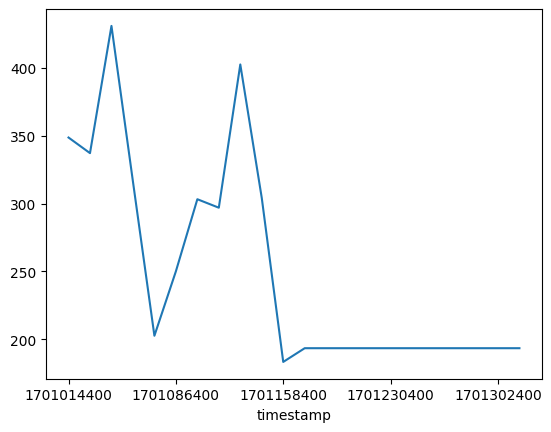

In [63]:
df_analysis.groupby('timestamp').leech.mean().plot()